**SOW-MKI49: Neural Information Processing Systems**  
*Weeks 6 and 7: Assignment (100 points + 20 bonus points)  
Author: Luca and Umut

# Group number: 17

1. Sameera Sandaruwan, s1014012
2. Mohit Jethwani, s1019474

# Notes
---
http://kvfrans.com/variational-autoencoders-explained/

However, there were a couple of downsides to using a plain GAN.

First, the images are generated off some arbitrary noise. If you wanted to generate a picture with specific features, there's no way of determining which initial noise values would produce that picture, other than searching over the entire distribution.

Second, a generative adversarial model only discriminates between "real" and "fake" images. There's no constraints that an image of a cat has to look like a cat. This leads to results where there's no actual object in a generated image, but the style just looks like picture.

In this post, I'll go over the variational autoencoder, a type of network that solves these two problems.

The more efficiently we can encode the original image, the higher we can raise the standard deviation on our gaussian until it reaches one.

https://github.com/chainer/chainer/blob/master/examples/vae/net.py

https://github.com/musyoku/variational-autoencoder/blob/master/vae_m1.py

---
## To Do

1. Search Variational autoencoder
2. Search Variational inference
3. Find Input and Output dimensions of dataset: 
Depends on our Network architecture. Network can be Convolutional (input is 28x28, output 1x10) or Linear (input is 1x784, output 1x10)
4. Check the architecture
5. How the loss function work here
6. figure out the architecture and what (X, Y, Z) are
7. Unit gaussian distribution

sdf

In [1]:
from chainer import cuda, datasets, serializers
from chainer.dataset import DatasetMixin, concat_examples
from chainer.iterators import MultithreadIterator
from chainer.iterators import SerialIterator
from chainer.optimizers import Adam, SGD, RMSprop
import chainer
import chainer.functions as F
import chainer.links as L
import cupy
import numpy as np
import tqdm
import time

model_directory = 'Model'
train_session = 'SGD_1e-3'
device = 0

# optimizer = Adam()
# optimizer = Adam(alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-08)
optimizer = SGD(lr=1e-3)
# optimizer = RMSprop()

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
n_in = 28*28
n_h = 1024
n_latent = 10
print(1e-3)

0.001


# Decoder
This is the decoder class. It transforms **latents (features) to observables (images)**. It corresponds to p(x | z) in the context of **variational inference** (and the slides), **where x is observables and y is latents.**

Task: (10 points)

- Implement the decoder class for a **variational autoencoder**. Note that the **decoder** should output the **Gaussian distribution parameters (mean and variance per pixel)** of images rather than images themselves.

In [4]:
class Decoder(chainer.ChainList):
    def __init__(self): # <= you might want to pass some architecture parameters (e.g., #i/o units, etc.) here
        super(Decoder, self).__init__(
            # pass your decoder layers here
            L.Linear(10, 500),
            L.Linear(500, 1024),
            L.Linear(1024, 1024),
            L.Linear(1024, 784),
            
            L.Linear(1024, 784),
        )

    def __call__(self, x):
        h = F.relu(self[0](x))
        h = F.relu(self[1](h))
        h = F.relu(self[2](h))
        mean_x = F.softmax(self[-1](h))
        ln_var_x = F.softmax(self[-2](h))
        
        return mean_x, ln_var_x

# Encoder
This is the encoder class. It transforms **observables (images) to latents (features)**. It corresponds to **q(z|x)** in the context of variational inference (and the slides), **where z is latents and x is observables**.

Task: (10 points)

- Implement the encoder class for a variational autoencoder. Note that the encoder should output the Gaussian distribution parameters (mean and variance per feature) of features rather than features themselves.

In [5]:
class Encoder(chainer.ChainList):
    def __init__(self): # <= you might want to pass some architecture parameters (e.g., #i/o units, etc.) here
        super(Encoder, self).__init__(
            # pass your encoder layers here
            L.Linear(784, 1024),
            L.Linear(1024, 1024),
            L.Linear(1024, 500),
            L.Linear(500, 10),
            
            L.Linear(500, 10),
        )

    def __call__(self, x):
        h = F.relu(self[0](x))
        h = F.relu(self[1](h))
        h = F.relu(self[2](h))
        mean_z = F.softmax(self[-2](h))
        ln_var_z = F.softmax(self[-1](h))
        
        return mean_z, ln_var_z
'''
https://www.kaggle.com/luyujia/mnist-chainer-cnn#
check this - https://github.com/musyoku/variational-autoencoder/blob/master/vae_m1.py

Convolutional Encoder  - backup
conv1 = L.Convolution2D(in_channels=1, out_channels=32, ksize=5),
conv2 = L.Convolution2D(in_channels=32, out_channels=64, ksize=5),
mean_z = L.Linear(1024, 10),
ln_var_z = L.Linear(1024, 10),

'''

'\nhttps://www.kaggle.com/luyujia/mnist-chainer-cnn#\ncheck this - https://github.com/musyoku/variational-autoencoder/blob/master/vae_m1.py\n\nConvolutional Encoder  - backup\nconv1 = L.Convolution2D(in_channels=1, out_channels=32, ksize=5),\nconv2 = L.Convolution2D(in_channels=32, out_channels=64, ksize=5),\nmean_z = L.Linear(1024, 10),\nln_var_z = L.Linear(1024, 10),\n\n'

# Loss
This is the loss class. The loss of encoder and decoder of a variational autoencoder is the evidence lower bound as follows:

$L = D_{KL}(q(z | x), p(z)) -  E_{z\sim q}[log~p(x | z)]$

The first term above is the KL divergence between the approximate posterior (q) and the prior (p), which can be interpreted as a form of regularization. You can assume that the prior is unit Gaussian. It can be implemented with the F.gaussian_kl_divergence function in Chainer.

The second term above is the Gaussian negative log likelihood. This is the term that fits the data, which is very similar to the usual loss functions that you use in deep learning. It can be implemented with the F.gaussian_nll function in Chainer.

Task: 

- Implement the loss class. (10 points)


As input, it gets the following arguments:

mean_z => mean of the encoded features (output of the encoder)  
ln_var_z => log variance of the encoded features (output of the encoder)  
x => input images (mini batch)  
mean_x => mean of the decoded images (output of the decoder)  
ln_var_x => mean of the decoded images (output of the decoder)  

As output, it gives the loss.

- Explain why we use log variance instead of variance. (5 points)

**Answer**


In [6]:
'''
# z_mean and z_stddev are two vectors generated by encoder network
latent_loss = 0.5 * tf.reduce_sum(tf.square(z_mean) + tf.square(z_stddev) - tf.log(tf.square(z_stddev)) - 1,1) 
'''

'\n# z_mean and z_stddev are two vectors generated by encoder network\nlatent_loss = 0.5 * tf.reduce_sum(tf.square(z_mean) + tf.square(z_stddev) - tf.log(tf.square(z_stddev)) - 1,1) \n'

In [7]:
# check this - https://github.com/musyoku/variational-autoencoder/blob/master/vae_m1.py
# https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/
# https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf
class Loss(object):
    def __call__(self, mean_z, ln_var_z, x, mean_x, ln_var_x):
        # Implement the loss here     
        '''
        1. KL divergence
        F.gaussian_kl_divergence
        
        𝐷𝐾𝐿(𝑞(𝑧|𝑥),𝑝(𝑧))
        
        '''
        dkl = F.gaussian_kl_divergence(mean_z, ln_var_z)
        '''
        2. Gaussian negative log likelihood
        F.gaussian_nll
        
        𝐸𝑧∼𝑞[𝑙𝑜𝑔(𝑝(𝑥|𝑧))]
        
        '''
        Gnll = F.gaussian_nll(x, mean_x, ln_var_x)
#         print('loss ', dkl, Gnll)
        return dkl + Gnll
        

# Model
This is the model class. It combines the encoder and the decoder.

Task: (20 points)

- Implement the reparameterziation trick for sampling latents. (10 points)



- Explain why we need to use this trick. (10 points)

**The latent loss, which is the KL divergence that measures how closely the latent variables match a unit gaussian. In order to optimize the KL divergence, we need the trick: instead of the encoder generating a vector of real values, it will generate a vector of means and a vector of standard deviations.**

In [8]:
class Model(chainer.Chain):
    def __init__(self, decoder, encoder):
        super(Model, self).__init__()

        with self.init_scope():
            self.decoder = decoder
            self.encoder = encoder

    def __call__(self, x):
        mean_z, ln_var_z = self.encoder(x)
        
        # Sample latents (z) from the Gaussian with parameters ln_var_z, mean_z by using the reparameterization trick
        '''
        https://www.jeremyjordan.me/variational-autoencoders/
        we can just sample from the standard deviations and add the mean, and use that as our latent vector: 
        samples = tf.random_normal([batchsize,n_z],0,1,dtype=tf.float32)  
        sampled_z = z_mean + (z_stddev * samples)
        '''
        z = np.random.normal(0, 1, 10) if device < 0 else cupy.random.normal(0, 1, 10)
#         z = np.random.normal(0, 1, 10)
        z = mean_z + (ln_var_z * z)
        mean_x, ln_var_x = self.decoder(z)

        return mean_z, ln_var_z, x, mean_x, ln_var_x

This is a helper class to use the Mnist dataset.

In [9]:
class Mnist(DatasetMixin):
    def __init__(self):
        self.dataset = datasets.get_mnist(False)[0 if chainer.config.train else 1]

    def __len__(self):
        return len(self.dataset)

    def get_example(self, i):
        return self.dataset[i]

Task: (50 points)

- Train the above defined variational autoencoder on the Mnist dataset. You can refer to the earlier assignments to implement your training loop. (25 points)

- How good are the samples? Randomy sample some digits and visualize them. (10 points)

- How good are the reconstructions? Draw an Mnist like digit, encode it, decode it and visualize the digits. How different is the reconstruction from the original. (10 points)

- Repeat the last task but by drawing something other than a digit (e.g., a face). How accuracte is the reconstructions? Explain the results. (5 points)

# Training

In [10]:
encoder = Encoder()
decoder = Decoder()
model = Model(decoder, encoder) if device < 0 else Model(decoder, encoder).to_gpu(device)

optimizer.setup(model)

### Prep dataset
batch_size = 100
training_set = Mnist()
training_iterator = SerialIterator(training_set, batch_size, False, True)
loss_history = {'training': [], 'validation': []}

lossFunc = Loss()

epochs_start = 0
epochs_end = 100

In [11]:
print("Training Started")
for i in range(epochs_start, epochs_end):
    epoch = i + 1
    loss_history['training'].append(0)
    start_time = time.time()
    for j, batch in enumerate(training_iterator):
        with chainer.using_config('train', True):
            x = concat_examples(batch=batch, device=device)
            mean_z, ln_var_z, x, mean_x, ln_var_x = model(x)
            loss = lossFunc(mean_z, ln_var_z, x, mean_x, ln_var_x)
            model.cleargrads()
            loss.backward()
            optimizer.update()

        loss_history['training'][-1] += float(loss.data)
#         print('train=',j,' loss=',loss)
    loss_history['training'][-1] /= j + 1
    print('>>> train | epoch = {} | time= {} sec | loss= {}'.format(i, (time.time() - start_time), 
                                                        loss_history['training'][-1]))
    training_iterator.reset()
    if (epochs_end==epoch):
        np.savez('{:s}/loss_history_ts_{:s}_{:03d}.npz'.format('Result', train_session, epoch), loss_history)
        serializers.save_npz('{:s}/model_ts_{:s}_{:03d}.npz'.format('Result', train_session, epoch), model)
        serializers.save_npz('{:s}/optimizer_ts_{:s}_{:03d}.npz'.format('Result', train_session, epoch), optimizer)
    else:
        np.savez('{:s}/loss_history_ts_{:s}_{:03d}.npz'.format(model_directory, train_session, epoch), loss_history)
        serializers.save_npz('{:s}/model_ts_{:s}_{:03d}.npz'.format(model_directory, train_session, epoch), model)
        serializers.save_npz('{:s}/optimizer_ts_{:s}_{:03d}.npz'.format(model_directory, train_session, epoch), optimizer)

print("Training Done")

Training Started
>>> train | epoch = 0 | time= 14.709107875823975 sec | loss= 76472.75220052083
>>> train | epoch = 1 | time= 14.88143253326416 sec | loss= 76430.63733072917
>>> train | epoch = 2 | time= 8.447000741958618 sec | loss= 76424.433828125
>>> train | epoch = 3 | time= 7.7985920906066895 sec | loss= 76415.7416015625
>>> train | epoch = 4 | time= 14.378607034683228 sec | loss= 76407.43986979166
>>> train | epoch = 5 | time= 8.211618423461914 sec | loss= 76400.63483072916
>>> train | epoch = 6 | time= 7.933697938919067 sec | loss= 76396.80346354167
>>> train | epoch = 7 | time= 11.023942470550537 sec | loss= 76395.15626302084
>>> train | epoch = 8 | time= 7.661799669265747 sec | loss= 76394.22373697917
>>> train | epoch = 9 | time= 7.668727397918701 sec | loss= 76393.5186328125
>>> train | epoch = 10 | time= 7.750056982040405 sec | loss= 76392.9967578125
>>> train | epoch = 11 | time= 7.7153613567352295 sec | loss= 76392.389296875
>>> train | epoch = 12 | time= 7.66372895240783

In [12]:
# print(loss_history['training'])

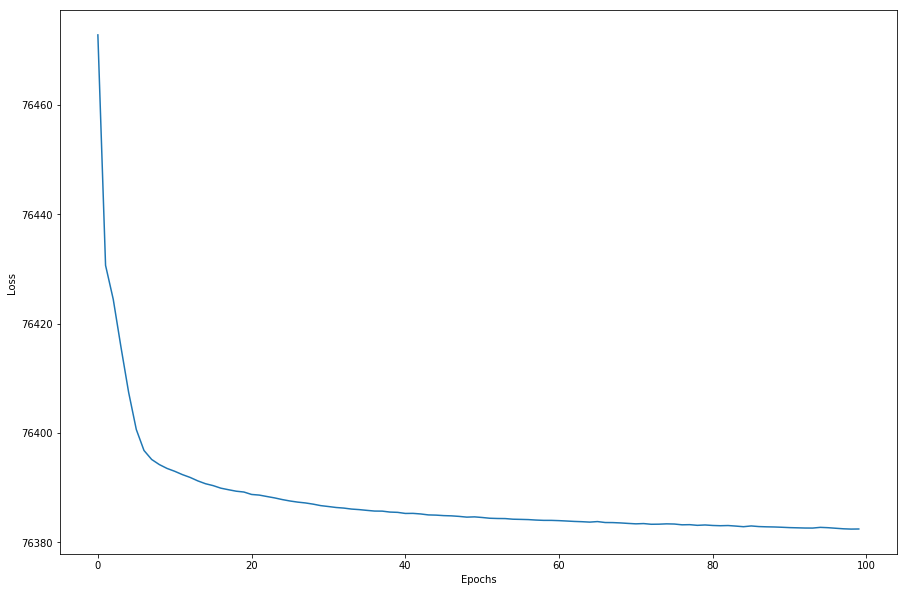

In [13]:
fig=plt.figure(figsize=(15, 10))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss_history['training'])

# Test

In [14]:
# encoder_T = Encoder()
# decoder_T = Decoder()
# model_T = Model(decoder_T, encoder_T) if device < 0 else Model(decoder_T, encoder_T).to_gpu(device)
# serializers.load_npz('{:s}/model_ts_{:s}_{:03d}.npz'.format('Result', train_session, epochs_end), model_T)

# lossFunc_T = Loss()

# batch_size = 100
# test_set = Mnist()
# test_iterator = SerialIterator(test_set, batch_size, False, True)

# test_history = []
# test_x = []
# test_mean_x = []
# test_var_x = []

# print('Test Starting...')
# for i in range(1):
#     epoch = i + 1
    
#     start_time = time.time()
#     for j, batch in enumerate(test_iterator):
#         with chainer.using_config('train', False):
#             x = concat_examples(batch=batch, device=device)
#             mean_z, ln_var_z, x, mean_x, ln_var_x = model_T(x)
#             loss = lossFunc_T(mean_z, ln_var_z, x, mean_x, ln_var_x)
#             test_x.append(x)
#             test_mean_x.append(mean_x)
#             test_var_x.append(ln_var_z)

#         test_history.append(float(loss.data))
# #         print('test epoch=',epoch,'test batch=',j,' loss=',loss)
#     np.savez('{:s}/test_loss_history_ts_{:s}_{:03d}.npz'.format('Result', train_session, epoch), test_history)
# print('Test Done...')


In [15]:
# if device<0:
#     in_x_1  =      test_x[0][0].reshape(28,28)
#     out_x_1 = test_mean_x[0][0].data.reshape(28,28)

#     in_x_2  =      test_x[0][1].reshape(28,28)
#     out_x_2 = test_mean_x[0][1].data.reshape(28,28)
# else:
#     in_x_1  =      test_x[0][0].get().reshape(28,28)
#     out_x_1 = test_mean_x[0][0].data.get().reshape(28,28)

#     in_x_2  =      test_x[0][1].get().reshape(28,28)
#     out_x_2 = test_mean_x[0][1].data.get().reshape(28,28)

# fig=plt.figure(figsize=(10, 10))

# plt.subplot(221)
# plt.title('Input (1)')
# plt.imshow(in_x_1)

# plt.subplot(222)
# plt.title('output (1)')
# plt.imshow(out_x_1)

# plt.subplot(223)
# plt.title('Input (2)')
# plt.imshow(in_x_2)

# plt.subplot(224)
# plt.title('output (2)')
# plt.imshow(out_x_2)

Bonus task: Try the same experiments on a different dataset. (20 bonus points)

http://ruishu.io/2018/03/14/vae/

# Optimizer Eval

76368.30516927084


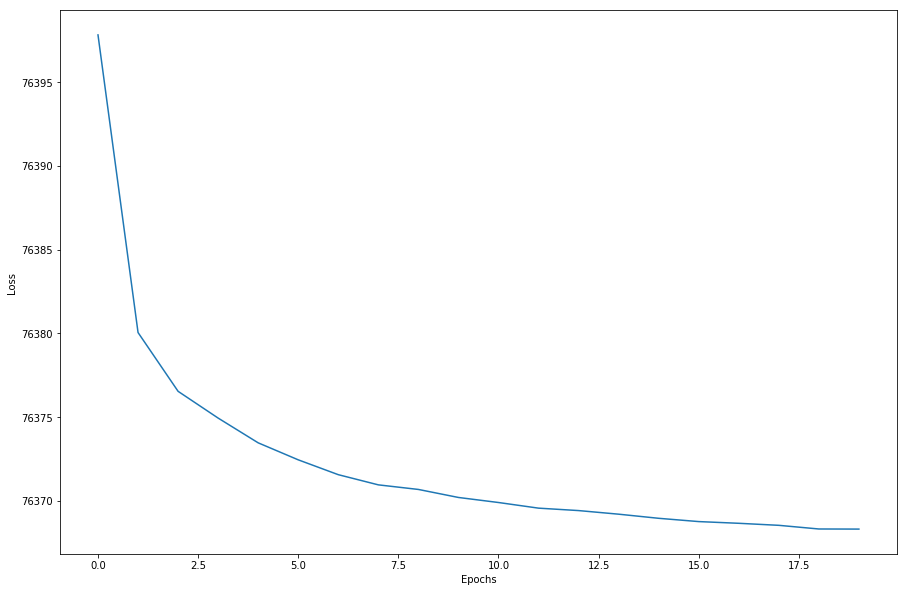

In [16]:
loss_His = np.load('{:s}/loss_history_ts_{:s}_{:03d}.npz'.format('Result', 'Adam', 20))
loss_His = loss_His[loss_His.files[0]]
loss_His = loss_His.reshape(1,)[0]

fig=plt.figure(figsize=(15, 10))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss_His['training'])

print(loss_His['training'][-1])

76388.58677083334


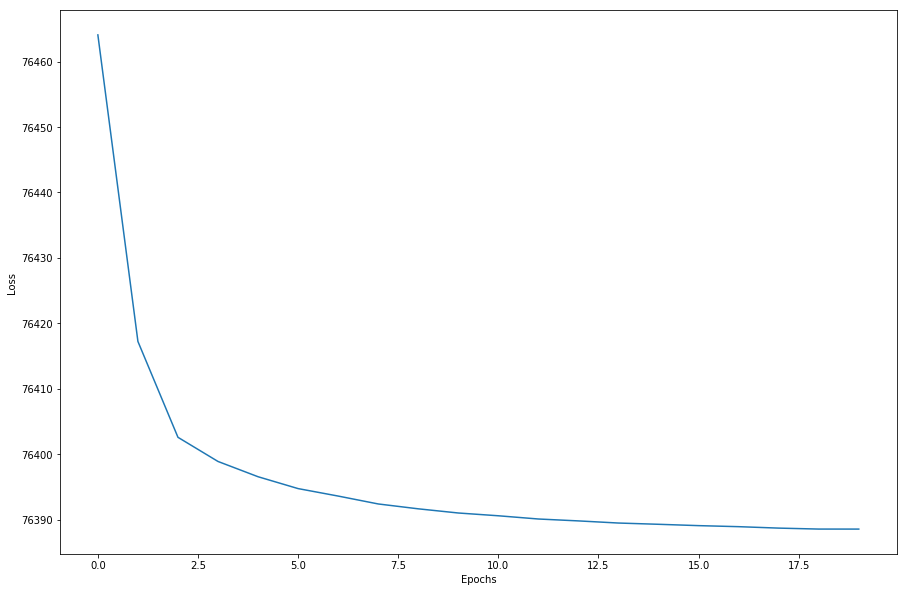

In [17]:
loss_His = np.load('{:s}/loss_history_ts_{:s}_{:03d}.npz'.format('Result', 'SGD', 20))
loss_His = loss_His[loss_His.files[0]]
loss_His = loss_His.reshape(1,)[0]

fig=plt.figure(figsize=(15, 10))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss_His['training'])

print(loss_His['training'][-1])

76579.274609375


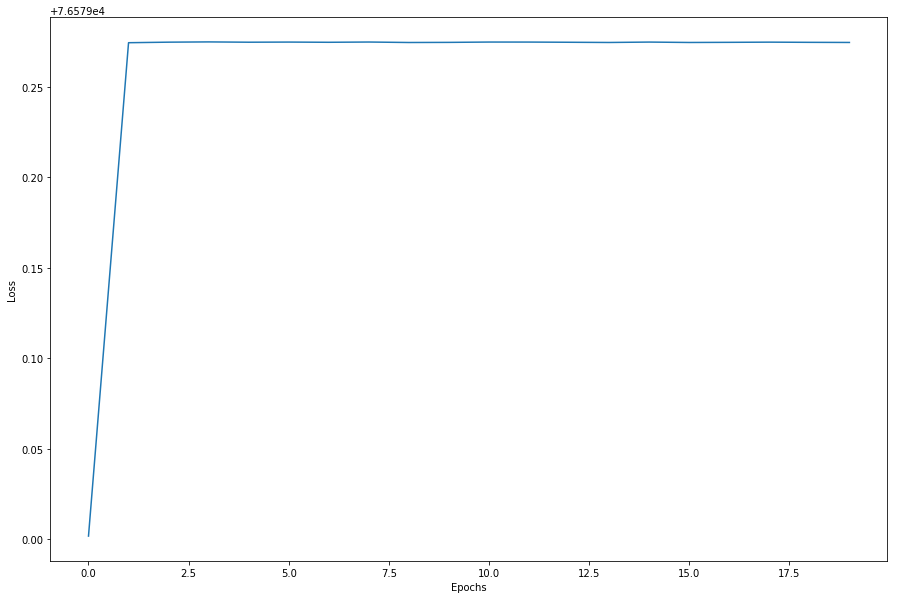

In [18]:
loss_His = np.load('{:s}/loss_history_ts_{:s}_{:03d}.npz'.format('Result', 'RMSprop', 20))
loss_His = loss_His[loss_His.files[0]]
loss_His = loss_His.reshape(1,)[0]

fig=plt.figure(figsize=(15, 10))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss_His['training'])

print(loss_His['training'][-1])